
<h1>Scikit-Learn</h1>


Cet exercice simule sur une mission pour une compagnie gérant un site web.<br>
On nous demande de prévoir l'âge et le sexe d'un internaute en regardant les pages qu'il visite. <br>
Vous avez donc deux fichiers dont chaque ligne représente un internaute :<br>
1) X : une colonne par page web, et le nombre de visites de l'internaute<br>
2) Y : des informations sur l'internaute : âge / sexe / âge bucketisé 

On demande de prévoir la tranche d'âge et le sexe en s'appuyant sur les informations de pages vues. <br>
Le notebook ci-après est un début de réponse à cette question.

# -1) Imports

In [3]:
%matplotlib inline
import pandas as pd
import os
import sys
import numpy as np
from datetime import datetime
from collections import defaultdict
import itertools

In [4]:
import scipy.stats as stats
import pylab
import matplotlib.pyplot as plot

# 0) Useful functions

In [5]:
def print_time():
    """
    Affiche et retourne l'heure de la machine.
    Utilisé pour mesurer le temps d'execution du classifieur.
    """
    import time
    import datetime
    t = datetime.datetime.now().time()
    #print t.isoformat()[:8]
    return time.time()

In [6]:
def draw_confusion_matrix(y_test, predictions, title):
    """
    Créé et affiche la matrice de confusion des données de Y_test et de celles sur lesquelles on a fait la prédiction.
    Permet d'évaluer la qualité de la classification souhaitée.
    Plus les valeurs diagonales sont élevées, plus le classifieur prédit correctement.
    """
    from sklearn.metrics import confusion_matrix,accuracy_score
    import matplotlib.pyplot as plt
    cm    = confusion_matrix(y_test, predictions)
    accur = accuracy_score  (y_test, predictions)
    
    plt.matshow  (cm)
    plt.ylabel   ('True Label')
    plt.xlabel   ('Predicted Label')
    plt.suptitle ('Confusion matrix (Accuracy of %.2f) for [%s]'%(accur,title))
    plt.colorbar ()
    plt.show     ()

In [7]:
def draw_roc_curve(fitted_c, x_test, y_test, title):
    """
    Créé et affiche la courbe ROC des données de test X et Y selon un classifieur (SVM, KNN, RF).
    Permet de représenter l'évolution de la vitesse d'apprentissage du classifieur.
    Taux de vrais-positifs en fonction du taux de faux-négatif.
    Plus l'aire sous la courbe est grande, plus le classifieur est idéal.
    """
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    c                                        = fitted_c
    probas                                   = c.predict_proba(x_test)
    false_positive_rate, recall_, thresholds = roc_curve(y_test, probas[:,1])
    roc_auc                                  = auc(false_positive_rate, recall_)
    
    plt.title  ('ROC %.2f %s'%(roc_auc, title))
    plt.legend (loc="lower right")
    plt.plot   ([0,1],[0,1], "r--")
    plt.plot   (false_positive_rate, recall_, 'b', label='AUC = %.2f'%roc_auc)
    plt.xlim   ([0.0,1.1])
    plt.ylim   ([0.0,1.1])
    plt.ylabel ('Recall')
    plt.xlabel ('Fall-out')
    plt.show()

# 1) Chargement des données

In [8]:
!open 

'open' n’est pas reconnu en tant que commande interne
ou externe, un programme exécutable ou un fichier de commandes.


In [9]:
X = pd.read_csv("base_x.csv", index_col=0)
#   Colonne (s) à utiliser comme étiquettes de ligne du DataFrame, données sous forme de nom de chaîne ou d'index de colonne. Si une séquence de int / str est donnée, un MultiIndex est utilisé.
#Remarque: index_col = False peut être utilisé pour forcer les pandas à ne pas utiliser la première colonne comme index, par exemple lorsque vous avez un fichier mal formé avec des délimiteurs à la fin de chaque ligne.

In [12]:
X

,aag.schlau,aag.schlaudanke,adac.aktuelleverkehrslage,adac.alpenstrassen,adac.alternativekraftstoffe,adac.andertankstelle,adac.auslandlzhome,adac.auslandlzkont,adac.auslandlzrechner,adac.auslkrankschkontaktfaq,...,wwtde.meetingoronline,wwtde.meetingsite,wwtde.mobileapp,wwtde.onlinesite,wwtde.propoints,wwtde.signupstep1,wwtde.signupstep2,wwtde.success,wwtde.worksonline,zentis.landingpage
10358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31328,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
 X.index

Int64Index([10358, 12227, 19120, 37547, 13441,  5985,  1224, 37153, 25611,
            35816,
            ...
             3442, 20729,  3756, 12160, 21925,  2336, 14865, 31328, 16692,
            31590],
           dtype='int64', length=39045)

In [13]:
Y = pd.read_csv("base_y.csv", index_col=0)

In [11]:
# Fait correspondre l'index des données X avec celles de Y
assert(sum(Y.index == X.index) == Y.shape[0])

# 1) First checks

In [22]:
[Y][0]

,bucket_en_entier,bucket,ID,Sex,Good sex prediction,age,Age predicted
10358,7,"(45, 65]",10359.0,1.0,1.0,56.0,3.0
12227,6,"(40, 45]",12228.0,1.0,1.0,43.0,1.0
19120,7,"(45, 65]",19121.0,0.0,1.0,61.0,3.0
37547,4,"(30, 35]",37548.0,1.0,1.0,32.0,2.0
13441,3,"(25, 30]",13442.0,1.0,1.0,29.0,1.0
...,...,...,...,...,...,...,...
2336,6,"(40, 45]",2337.0,1.0,1.0,43.0,1.0
14865,4,"(30, 35]",14866.0,0.0,1.0,32.0,3.0
31328,4,"(30, 35]",31329.0,0.0,1.0,35.0,1.0
16692,7,"(45, 65]",16693.0,1.0,1.0,50.0,1.0


In [24]:
# Statistiques descriptives
# Nombre de row, de variable, nb de modalité de la variable âge
# Moyenne, écart type, quartiles, déciles

for data in [Y]:
    title = "Number of rows and columns"
    print ("% 35s : %s rows, %s columns "%(title, data.shape[0], data.shape[1]))
    title = "Number of categorical variables"
    print ("% 35s : 1 variable, and 10 modalities"%title)
    title = "Number of values by modality" 
    print ("% 35s :"% (title))
    t = data.bucket.value_counts()
    t = t.sort_index()
    for x,y in t.iteritems():
        print ("% 37s % 9s % 5s"%("", x,y))

    title = "Moyenne des âges"
    print ("% 35s : %.1f"%(title, data.age.mean()))
    title = "Ecart type"
    print ("% 35s : %.1f"%(title,data.age.std()))

    quartiles = {}
    for i in range(5):
        quartiles[i] = np.percentile(data.age, i*100/4)

    title = "Frontière des Quartiles"
    print ("% 35s : %s"%(title, " , ".join(["%s"%y for x,y in quartiles.items()])))

    title = "Ecartement inter quartile"
    print ("% 35s : %s"%(title, " , ".join(["%s"%(quartiles[i]-quartiles[i-1]) for i in range(1,5)])))


    decile = {}
    for i in range(10):
        decile[i] = np.percentile(data.age, i*100/10)
    title = "Frontière des Deciles"
    print ("% 35s : %s"%(title, " , ".join(["%s"%y for x,y in decile.items()])))

    title = "Ecartement inter decile"
    print ("% 35s : %s"%(title, " , ".join(["%s"%(decile[i]-decile[i-1]) for i in range(1,10)])))

# REMARQUES :
# La répartition de la population dans les catégories d'âge n'est pas homogène
# Certaines classes d'âge sont sous-représentées (jeunes, vétérans)

         Number of rows and columns : 39045 rows, 7 columns 
    Number of categorical variables : 1 variable, and 10 modalities
       Number of values by modality :
                                       (14, 18]   151
                                       (18, 20]   357
                                       (20, 25]  1734
                                       (25, 30]  4070
                                       (30, 35]  4150
                                       (35, 40]  4702
                                       (40, 45]  4591
                                       (45, 65] 16136
                                       (65, 70]  1743
                                      (70, 150]  1411
                   Moyenne des âges : 45.5
                         Ecart type : 13.6
            Frontière des Quartiles : 18.0 , 35.0 , 45.0 , 55.0 , 95.0
          Ecartement inter quartile : 17.0 , 10.0 , 10.0 , 40.0
              Frontière des Deciles : 18.0 , 28.0 , 33.0 , 37.0 , 41.0 ,

## L'âge est-il normal ?

((array([-4.13494008, -3.92652537, -3.81279465, ...,  3.81279465,
          3.92652537,  4.13494008]),
  array([18., 18., 18., ..., 94., 95., 95.])),
 (13.475733117621878, 45.471046228710456, 0.9929491353419291))

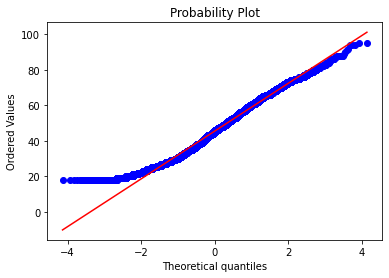

In [11]:
# Répartition des ages selon les quantiles (création d'intervalles contenant le même nombre de données)
stats.probplot(Y.age, dist="norm", plot=pylab)

# 2) Binarization des âges

In [30]:
# Mise en place de nouveaux intervalles d'âge pour obtenir une meilleur répartition de la population dans les classes d'âge
bins = np.array([13,19,24,29,34,39,44,49,54,59,100])
labels = pd.cut(data.age, bins)
Y['bucketed_age'] = labels
Y

,bucket_en_entier,bucket,ID,Sex,Good sex prediction,age,Age predicted,bucketed_age
10358,7,"(45, 65]",10359.0,1.0,1.0,56.0,3.0,"(54, 59]"
12227,6,"(40, 45]",12228.0,1.0,1.0,43.0,1.0,"(39, 44]"
19120,7,"(45, 65]",19121.0,0.0,1.0,61.0,3.0,"(59, 100]"
37547,4,"(30, 35]",37548.0,1.0,1.0,32.0,2.0,"(29, 34]"
13441,3,"(25, 30]",13442.0,1.0,1.0,29.0,1.0,"(24, 29]"
...,...,...,...,...,...,...,...,...
2336,6,"(40, 45]",2337.0,1.0,1.0,43.0,1.0,"(39, 44]"
14865,4,"(30, 35]",14866.0,0.0,1.0,32.0,3.0,"(29, 34]"
31328,4,"(30, 35]",31329.0,0.0,1.0,35.0,1.0,"(34, 39]"
16692,7,"(45, 65]",16693.0,1.0,1.0,50.0,1.0,"(49, 54]"


In [31]:
labels2 = pd.cut(data.age, 5)
labels2

10358      (48.8, 64.2]
12227      (33.4, 48.8]
19120      (48.8, 64.2]
37547    (17.923, 33.4]
13441    (17.923, 33.4]
              ...      
2336       (33.4, 48.8]
14865    (17.923, 33.4]
31328      (33.4, 48.8]
16692      (48.8, 64.2]
31590      (48.8, 64.2]
Name: age, Length: 39045, dtype: category
Categories (5, interval[float64]): [(17.923, 33.4] < (33.4, 48.8] < (48.8, 64.2] < (64.2, 79.6] < (79.6, 95.0]]

In [32]:
dataSerie = pd.Series(Y.bucketed_age)
dataSerie

10358     (54, 59]
12227     (39, 44]
19120    (59, 100]
37547     (29, 34]
13441     (24, 29]
           ...    
2336      (39, 44]
14865     (29, 34]
31328     (34, 39]
16692     (49, 54]
31590     (49, 54]
Name: bucketed_age, Length: 39045, dtype: category
Categories (10, interval[int64]): [(13, 19] < (19, 24] < (24, 29] < (29, 34] ... (44, 49] < (49, 54] < (54, 59] < (59, 100]]

In [36]:
x = dataSerie.sort_values()
x

7365      (13, 19]
24987     (13, 19]
11705     (13, 19]
19547     (13, 19]
29092     (13, 19]
           ...    
16527    (59, 100]
27673    (59, 100]
12293    (59, 100]
33660    (59, 100]
25729    (59, 100]
Name: bucketed_age, Length: 39045, dtype: category
Categories (10, interval[int64]): [(13, 19] < (19, 24] < (24, 29] < (29, 34] ... (44, 49] < (49, 54] < (54, 59] < (59, 100]]

In [37]:
x = dataSerie.value_counts()
x

(59, 100]    6708
(44, 49]     5344
(34, 39]     4740
(49, 54]     4580
(39, 44]     4468
(29, 34]     4068
(24, 29]     3771
(54, 59]     3654
(19, 24]     1394
(13, 19]      318
Name: bucketed_age, dtype: int64

In [38]:
x.index

CategoricalIndex([(59, 100],  (44, 49],  (34, 39],  (49, 54],  (39, 44],
                   (29, 34],  (24, 29],  (54, 59],  (19, 24],  (13, 19]],
                 categories=[(13, 19], (19, 24], (24, 29], (29, 34], (34, 39], (39, 44], (44, 49], (49, 54], ...], ordered=True, dtype='category')

In [34]:
x = x.sort_index()
x

(13, 19]      318
(19, 24]     1394
(24, 29]     3771
(29, 34]     4068
(34, 39]     4740
(39, 44]     4468
(44, 49]     5344
(49, 54]     4580
(54, 59]     3654
(59, 100]    6708
Name: bucketed_age, dtype: int64

<AxesSubplot:title={'center':'Age prediction :a  multi-class classification problem'}>

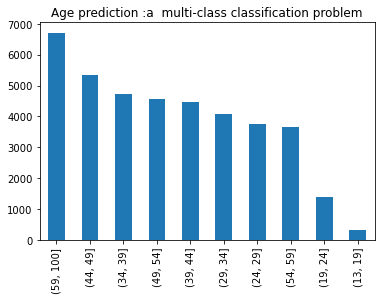

In [39]:
title="Age prediction :a  multi-class classification problem"
x.plot(kind="bar", title=title)

# Le problème de répartition dans les classes d'âge semble mieux appréhendé, cependant il est encore un peu présent

# 4) Grid search

In [40]:
def RandomForest_grid_search(df, Y):
    """
    Réglage des hyper-paramètres du classifieur Random Forest
    """
    import sys, pickle
    from sklearn.ensemble          import RandomForestClassifier
    from sklearn.model_selection   import GridSearchCV
    from sklearn.metrics           import make_scorer
    from sklearn.preprocessing     import label_binarize
    from sklearn.multiclass        import OneVsRestClassifier
    #grid search :

    parameters = {  "n_estimators"         : [ 10, 100, 200 ], 
                    "min_samples_leaf"     : [  3,   1,   7 ],
                    "criterion"            : ["gini"],#["gini", "entropy"]         ,
                    "max_features"         : ["auto"]      ,
                    "max_depth"            : [None]         , 
                    "n_jobs"               : [ -1]             ,  
                    "class_weight"         : ["auto"]          ,
                    "warm_start"           : [False]           }
    parameters = {  "n_estimators"         : [ 10], 
                    "min_samples_leaf"     : [  3 ],
                    "criterion"            : ["gini"],#["gini", "entropy"]         ,
                    "max_features"         : ["auto"]      ,
                    "max_depth"            : [None]         , 
                    "n_jobs"               : [ -1]             ,  
                    "class_weight"         : ["auto"]          ,
                    "warm_start"           : [False]           }
    
    grid_type = "RandomForestClassifier"
    
    print ("-"*30, "\n %s"%grid_type); sys.stdout.flush()
    """
        Search 
    """
    
    grid         = GridSearchCV(RandomForestClassifier(), {})#, parameters, verbose=1, scoring='f1_weighted')
    
    try :grid.fit(df, Y)
    except Exception as e : print ("[%s - 2] : %s"%(grid_type,e) )
    
    print (" best_score_ %s with =  %s "%( grid.best_score_,  grid.best_estimator_ ) ); sys.stdout.flush()    
    return grid.best_estimator_

In [41]:
def svm_grid_search(df, Y):
    """
    Réglage des hyper-paramètres du classifieur Support Vector Machine
    Notamment : 'C', 'kernel' et 'gamma'
    """
    import sys
    from sklearn.model_selection   import GridSearchCV
    from sklearn.svm               import SVC
    import pickle
    parameters = {  "C"              : [1.0],#, 0.5, 0.1, 2]                , 
                    "kernel"         : ['rbf'],#, 'poly', 'sigmoid']        ,
                    "degree"         : [2],#, 3, 4,5,6]                     , 
                    "gamma"          : [0.01],#, 0.1, 0.001, 0.5]           , 
                    "coef0"          : [0.0]                             , 
                    "shrinking"      : [True]                            , 
                    "probability"    : [True]                            , 
                    "tol"            : [0.001]                           , 
                    "cache_size"     : [10]                              , 
                    "class_weight"   : [None]                            , 
                    "verbose"        : [False]                           , 
                    "max_iter"       : [-1]                              , 
                    "random_state"   : [None]                            }
   
    
    
    print ("-"*30, "\n svm_grid_search"); sys.stdout.flush()
    
    """
        Search Grid
    """
    grid    = GridSearchCV(SVC(), parameters, verbose=0, scoring='f1_weighted')
    try :grid.fit(df, Y)
    except Exception as e : 
        print ("[svm_grid_search - 2] : %s"%e) ; 
        print ("x_train, y_train : ", x_train, y_train)

    print (" best_score_ = %.2f with =  %s "%(grid.best_score_, grid.best_estimator_ ) ); sys.stdout.flush()    
    return grid.best_estimator_

In [42]:
def knn_grid_search(df, Y):
    """
    Réglage des hyper-paramètres du classifieur K Nearest Neighbors
    Plusieurs hyper-paramètres sont disponibles
    L'entrainement du modèle va s'effectuer sur plusieurs paramètres
    Le best_score représentera le modèle avec les meilleurs paramètres
    """
    import sys
    from sklearn.model_selection   import GridSearchCV
    from sklearn.neighbors         import KNeighborsClassifier
    
    import pickle

    parameters = {  "n_neighbors"    : [2, 3, 5, 8 , 10]                         , 
                    "weights"         : ['uniform', 'distance']                  ,
                    "algorithm"      : ['auto', 'ball_tree', 'kd_tree', 'brute'] , 
                    "leaf_size"      : [1,3 ]                                    }
    
    
    grid_type = "knn_grid_search"
    print ("-"*30, "\n %s"%grid_type); sys.stdout.flush()
    """
        Search Grid
    """
    print (parameters);sys.stdout.flush()
    grid    = GridSearchCV(KNeighborsClassifier(), parameters, verbose=0, scoring='f1_weighted')
    try :grid.fit(df, Y)
    except Exception as e : print ("Error : [%s - 2] : %s"%(grid_type,e) ); return -1

    
    print (" best_score_ = %.2f with =  %s "%(grid.best_score_, grid.best_estimator_ ) ); sys.stdout.flush()    
    return grid

In [43]:
def clf_grid_search(df, Y):
    """
    Réglage des hyper-paramètres du Classifier Gradient Boosting
    """
    import sys
    from sklearn.model_selection   import GridSearchCV
    from sklearn.neighbors         import KNeighborsClassifier
    from sklearn import ensemble
    from sklearn import datasets
    from sklearn.utils import shuffle
    from sklearn.metrics import mean_squared_error
    from sklearn.datasets import make_hastie_10_2
    from sklearn.ensemble import GradientBoostingClassifier
    
    import pickle

    parameters = {'n_estimators': 10                       ,
                  'max_depth': None                        ,
                  'min_samples_split': 2                   ,
                  'learning_rate': 0.01                    ,
                  'loss': 'ls'                             }
    
    grid_type = "clf_grid_search"
    print ("-"*30, "\n %s"%grid_type); sys.stdout.flush()
    """
        Search Grid
    """
    print (parameters);sys.stdout.flush()
    
    
    grid = GridSearchCV(GradientBoostingClassifier(), {})
    try :grid.fit(df, Y)
    except Exception as e : print ("Error : [%s - 2] : %s"%(grid_type,e) ); return -1
    print (" best_score_ = %.2f with =  %s "%(grid.best_score_, grid.best_estimator_ ) ); sys.stdout.flush()    
    return grid

# 5) Application grid search

## 5.1) Variable : Age

In [44]:
!pip install sklearn

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1321 sha256=9658d89f0acecb85247d756a6c97f3af0d8da8116188b7067d72e2367206b27e
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\22\0b\40\fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn


In [45]:

from sklearn.model_selection import train_test_split

In [46]:
# Split des données originales en données d'entrainement et de test
# La classification se fait en fonction de la variable 'age' 
# 75% de données de d'entrainement
# 25% de données de test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y.bucket_en_entier)

In [47]:
Y_train

14652    7
8654     3
15393    9
10373    6
21698    9
        ..
27568    7
28396    7
22893    4
20549    3
18529    3
Name: bucket_en_entier, Length: 29283, dtype: int64

### 5.1.1) SVM

In [24]:
# Temps de calculs : 
#100 rows : 1.8s / 0.42 pred
#200 rows : 6.5s / 0.42 pred
#300 rows : 15s  / 0.42 pred
#400 rows : 26s  / 0.42 pred
#500 rows : 43s  / 0.42 pred
#600 rows : 64s  / 0.42 pred
#700 rows : 89s  / 0.42 pred

nb_lignes = 100
start_time = print_time()

# Apprentissage du classifieur SVM sur X_train et Y_train (<nb_lignes> données)
svm = svm_grid_search(X_train[:nb_lignes], Y_train[:nb_lignes].values)

end_time = print_time()
print ("\nDuration time :", end_time - start_time)
# Faites varier le nombre de lignes ! 

------------------------------ 
 svm_grid_search


C:\Users\io201817\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


 best_score_ = 0.21 with =  SVC(cache_size=10, degree=2, gamma=0.01, probability=True) 

Duration time : 2.4936773777008057


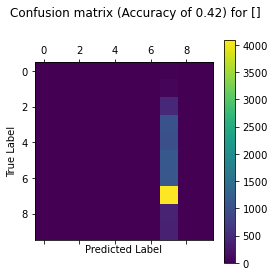

In [25]:
# Matrice de confusion des données X_test sur lesquelles on fait la prédiction et des données Y_test.
# La catégorie d'âge [45,65] semble être celle sur laquelle la prédiction se fait le mieux.
# Cependant la précision du modèle étant de 0.42, au mieux, n'est pas du tout concevable dans un modèle prédictif.

draw_confusion_matrix(Y_test, svm.predict(X_test), "") #Y_test possède seulement la variable 'bucket_en_entier'.

### 5.1.2) KNN

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y.bucket_en_entier)

In [27]:
#30 rows  : 4.39s / 0.42 acc
nb_ligne = 30
start_time = print_time()

# Apprentissage du classifieur KNN sur X_train et Y_train (<nb_lignes> données)
knn = knn_grid_search(X_train[:nb_ligne], Y_train[:nb_ligne].values)


end_time = print_time()
print ("\nDuration time :", end_time - start_time)


------------------------------ 
 knn_grid_search
{'n_neighbors': [2, 3, 5, 8, 10], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'leaf_size': [1, 3]}


C:\Users\io201817\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


 best_score_ = 0.17 with =  KNeighborsClassifier(leaf_size=1, n_neighbors=10, weights='distance') 

Duration time : 32.37677788734436


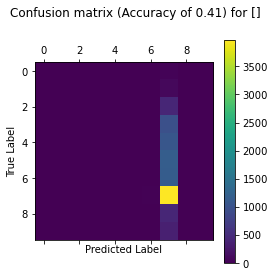

In [28]:
# La  matrice de confusion s'améliore, tout en étant loin de la réalité.
draw_confusion_matrix(Y_test, knn.predict(X_test), "")

### 5.1.3) CLF

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y.bucket_en_entier)

In [30]:
#30 rows  : 2.53s / 0.42 acc
#200 rows  : 2.53s / 0.42 acc
nb_ligne = 200
start_time = print_time()

# Apprentissage du classifieur KNN sur X_train et Y_train (<nb_lignes> données)
clf = clf_grid_search(X_train[:nb_ligne], Y_train[:nb_ligne].values)


end_time = print_time()
print ("\nDuration time :", end_time - start_time)


------------------------------ 
 clf_grid_search
{'n_estimators': 10, 'max_depth': None, 'min_samples_split': 2, 'learning_rate': 0.01, 'loss': 'ls'}
 best_score_ = 0.39 with =  GradientBoostingClassifier() 

Duration time : 115.00701761245728


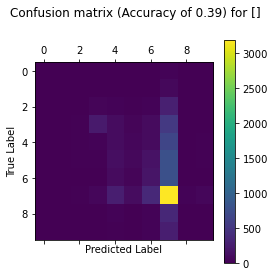

In [31]:
# CLF ne semble pas non plus adapté au vue de la précision du modèle
draw_confusion_matrix(Y_test, clf.predict(X_test), "")

## 5.2) Variable : Sex

In [32]:
# La classification se fait en fonction de la variable 'sex' 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y.Sex)

### 5.2.1) Random Forest

In [33]:
#200   rows : 0.26s / 0.68 pred / 0.66 acc
#2000  rows : 1.55s / 0.74 pred / 0.68 acc
#20000 rows : 15.5s / 0.78 pred / 0.72 acc
nb_lignes = 2000
start_time = print_time()

# Apprentissage du classifieur RF sur X_train et Y_train (<nb_lignes> données)
rf = RandomForest_grid_search(X_train[:nb_lignes], Y_train[:nb_lignes])

end_time = print_time()
print ("\nDuration time :", end_time - start_time)

# REMARQUES :
# L'utilisation du classifieur RF semble approprié pour faire une prédiction sur les données que l'on possède.
# L'entrainement du classifieur nécessite 15 secondes pour près de 20 000 données semble tout à fait raisonnable.

------------------------------ 
 RandomForestClassifier
 best_score_ 0.7185 with =  RandomForestClassifier() 

Duration time : 15.605802059173584


No handles with labels found to put in legend.


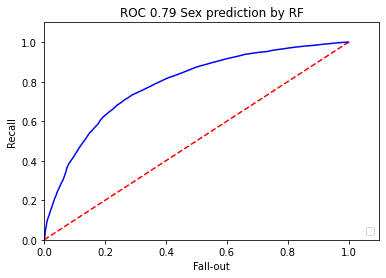

In [34]:
# Courbe ROC des données de test X et Y selon le classifieur RF
# Au mieux, le classifieur à une performance de 0.78 pour la prédiction du sexe
draw_roc_curve(rf, X_test, Y_test, "Sex prediction by RF")

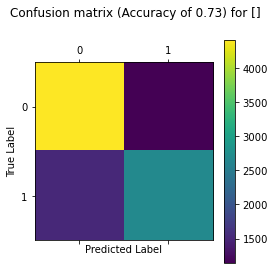

In [35]:
# Matrice de confusion des données X_test sur lesquelles on fait la prédiction et des données Y_test.
# La prédiction du modèle étant de 0.72, au mieux, commence à être correct.
# Un grand nombre de Vrais Positifs et Vrais Négatifs sont présents.
draw_confusion_matrix(Y_test, rf.predict(X_test), "")

### 5.2.2) SVM

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y.Sex)

In [37]:
#100 rows : 0.82s / 0.5 pred  / 0.57 acc
#200 rows : 2.7s  / 0.5 pred  / 0.57 acc
#300 rows : 6.1s  / 0.42 pred / 0.57 acc
#400 rows : 11 s  / 0.49 pred / 0.57 acc
#500 rows : 21s   / 0.50 pred / 0.57 acc
#600 rows : 25s   / 0.52 pred / 0.58 acc
nb_ligne = 300
start_time = print_time()

# Apprentissage du classifieur SVM sur X_train et Y_train (<nb_lignes> données)
svm = svm_grid_search(X_train[:nb_ligne], Y_train[:nb_ligne])

end_time = print_time()
print ("\nDuration time :", end_time - start_time)

# REMARQUES :
# L'utilisation du classifieur SVM ne semble toujours pas très approprié pour faire des prédictions sur nos données.
# D'autre part, le temps nécessaire pour faire un apprentissage pour entrainer le classifieur svm est toujours trop important
# au vue du nombre de données que l'on lui fournit.

------------------------------ 
 svm_grid_search
 best_score_ = 0.45 with =  SVC(cache_size=10, degree=2, gamma=0.01, probability=True) 

Duration time : 18.237579345703125


No handles with labels found to put in legend.


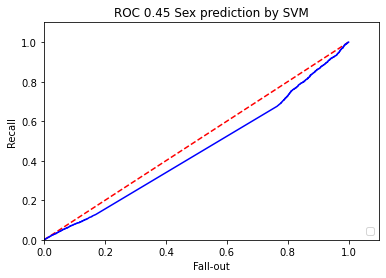

In [38]:
# Courbe ROC des données de test X et Y selon le classifieur SVM 
# Au mieux, le classifieur à une performance de 0.52 pour la prédiction du sexe
# Nous pouvons dire que la classification se fait quasiment de manière aléatoire puisque la courbe se rapproche de la droite diagonale
draw_roc_curve(svm, X_test, Y_test, "Sex prediction by SVM")

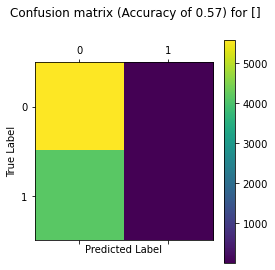

In [39]:
# Matrice de confusion des données X_test sur lesquelles on fait la prédiction et des données Y_test.
# La prédiction du modèle étant de 0.58, au mieux, n'est pas satisfaisant.
# Un nombre trop important de Faux Positif est présent.
# Le classifieur SVM ne semble toujours pas adapté pour effectuer une prédiction sur nos données.
draw_confusion_matrix(Y_test, svm.predict(X_test), "")

### 5.2.3) KNN

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y.Sex)

In [41]:
#15 rows  : 2.7s   / 0.5  pred / 0.52 acc
#30 rows  : 4.5s   / 0.51 pred / 0.53 acc
#50 rows  : 9.8s   / 0.51 pred / 0.53 acc
#75 rows  : 16s    / 0.53 pred / 0.55 acc
#200 rows : 102s   / 0.63 pred / 0.60 acc
#400 rows : 289s   / 0.66 pred / 0.62 acc
#1000 rows : 1387s / 0.69 pred / 0.68
nb_ligne = 30
start_time = print_time()

# Apprentissage du classifieur KNN sur X_train et Y_train (<nb_lignes> données)
knn = knn_grid_search(X_train[:nb_ligne], Y_train[:nb_ligne])

end_time = print_time()
print ("\nDuration time :", end_time - start_time)

# REMARQUES :
# L'utilisation du classifieur KNN ne semble pas très adapté pour effectuer un apprentissage sur nos données.
# Bien que la prédiction du modèle semble à peu près correct, le temps nécessaire pour un apprentissage sur un nombre
# aussi réduit de données n'est pas viable.

------------------------------ 
 knn_grid_search
{'n_neighbors': [2, 3, 5, 8, 10], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'leaf_size': [1, 3]}
 best_score_ = 0.64 with =  KNeighborsClassifier(leaf_size=1, n_neighbors=2) 

Duration time : 42.26725459098816


No handles with labels found to put in legend.


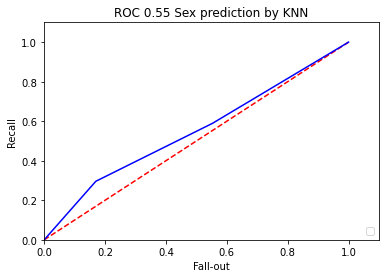

In [42]:
# Courbe ROC des données de test X et Y selon le classifieur KNN
# Au mieux, le classifieur à une performance de 0.69 pour la prédiction du sexe (mais nécessitant un temps assez important)
# Plus l'apprentissage se fait sur un nombre de données, plus l'indice de prédiction augmente.
# Pour obtenir un tel résultat, le temps nécessaire est tout de même trop important.
draw_roc_curve(knn, X_test, Y_test, "Sex prediction by KNN")

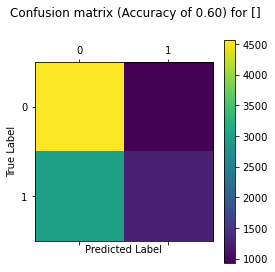

In [43]:
# Matrice de confusion des données X_test sur lesquelles on fait la prédiction et des données Y_test.
# La prédiction du modèle étant de 0.62, au mieux, est tout juste satisfaisant.
# Le classifieur SVM semble pouvoir effectuer une prédiction assez correcte, mais le temps nécessaire est
# la principale contrainte de ce classifieur.
draw_confusion_matrix(Y_test, knn.predict(X_test), "")

### 5.2.4) CLF

In [44]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y.Sex)

In [45]:
#100   rows : 2.3s / 0.71 pred / 0.65 acc
#1000  rows : 18s  / 0.82 pred / 0.75 acc
#5000  rows : 122s / 0.85 pred / 0.78 acc
nb_ligne = 1000
start_time = print_time()

clf = clf_grid_search(X_train[:nb_ligne], Y_train[:nb_ligne])

end_time = print_time()
print ("\nDuration time :", end_time - start_time)

------------------------------ 
 clf_grid_search
{'n_estimators': 10, 'max_depth': None, 'min_samples_split': 2, 'learning_rate': 0.01, 'loss': 'ls'}
 best_score_ = 0.70 with =  GradientBoostingClassifier() 

Duration time : 72.57608938217163


No handles with labels found to put in legend.


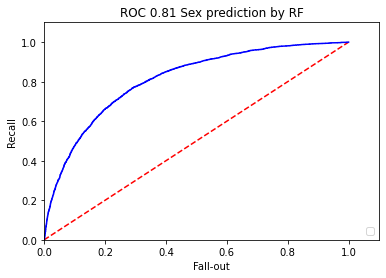

In [46]:
# Courbe ROC des données de test X et Y selon le classifieur CLF
# Au mieux, le classifieur à une performance de 0.85 pour la prédiction du sexe
# La classification se fait plutôt correctement au vue de la performance du classifieur
draw_roc_curve(clf, X_test, Y_test, "Sex prediction by RF")

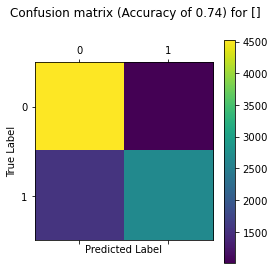

In [47]:
# Matrice de confusion des données X_test sur lesquelles on fait la prédiction et des données Y_test.
# Le classifieur CLF est  satisfaisant sur nos données
draw_confusion_matrix(Y_test, clf.predict(X_test), "")

# Le Classifier Gradient Boosting semble être le meilleur modèle de prédiction que nous avons testé jusqu'ici
# La prédiction et la précision sont les plus élevées que nous avons enregistré jusqu'ici

In [48]:
# Faites varier le nombre de lignes d'apprentissage pour améliorer les prédictions